In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
sns.set_palette('husl')

## 1. 모델 버전 및 데이터 로드

In [ ]:
# 분석할 모델 버전 설정
MODEL_VERSION = "20251125_123705"  # 분석할 모델 버전
MODEL_DIR = Path(f'../models/{MODEL_VERSION}')

# Training history 로드
history_path = MODEL_DIR / 'training_history.json'

if not history_path.exists():
    print(f"Error: Training history not found at {history_path}")
    print("Please specify a valid model version.")
    print(f"Available models:")
    models_dir = Path('../models')
    if models_dir.exists():
        for model in models_dir.iterdir():
            if model.is_dir():
                print(f"  - {model.name}")
else:
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    print(f"Loaded training history for version: {MODEL_VERSION}")
    print(f"Total epochs: {len(history['epoch'])}")
    print(f"Best validation loss: {min(history['val_loss']):.4f}")


Error: Training history not found at ../models/20251125_completed/training_history.json
Please specify a valid model version.


In [7]:
# Config 로드
config_path = MODEL_DIR / 'config.json'
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
else:
    print(f"Warning: Config not found at {config_path}")
    config = {}

# 학습 이력 DataFrame으로 변환
history_df = pd.DataFrame(history)

print("모델 설정:")
print(f"  - 버전: {MODEL_VERSION}")
if config:
    print(f"  - 입력 차원: {config.get('input_dim', 'N/A')}")
    print(f"  - 은닉층: {config.get('hidden_dims', 'N/A')}")
    print(f"  - Horizon: {config.get('horizon', 'N/A')}")
    print(f"  - Best Epoch: {config.get('best_epoch', 'N/A')}")
    print(f"  - Best Val Loss: {config.get('best_val_loss', 'N/A')}")
    print(f"\n학습 데이터:")
    print(f"  - 학습 샘플: {config.get('num_train_samples', 'N/A')}")
    print(f"  - 검증 샘플: {config.get('num_val_samples', 'N/A')}")
print(f"\n총 에폭 수: {len(history_df)}")


NameError: name 'history' is not defined

## 2. 에폭별 Loss 변화 분석

NameError: name 'history_df' is not defined

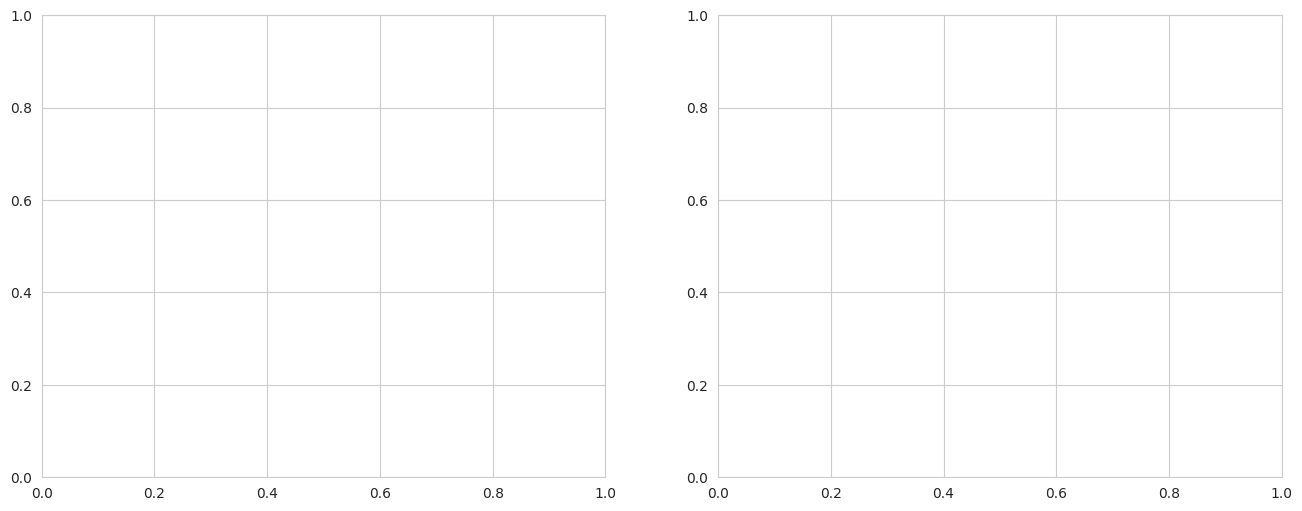

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss 변화
axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', marker='s', markersize=3)
if 'best_epoch' in config:
    axes[0].axvline(config['best_epoch'], color='red', linestyle='--', alpha=0.7, label=f"Best Epoch ({config['best_epoch']})")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss 차이 (Overfitting 감지)
loss_diff = history_df['val_loss'] - history_df['train_loss']
axes[1].plot(history_df['epoch'], loss_diff, marker='o', markersize=3, color='orange')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Val Loss - Train Loss')
axes[1].set_title('Overfitting Indicator (Val Loss - Train Loss)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계
print(f"최종 Train Loss: {history_df['train_loss'].iloc[-1]:.6f}")
print(f"최종 Val Loss: {history_df['val_loss'].iloc[-1]:.6f}")
print(f"최종 Loss 차이: {loss_diff.iloc[-1]:.6f}")
print(f"평균 Loss 차이: {loss_diff.mean():.6f}")

## 3. 에폭별 정확도 변화 분석

NameError: name 'history_df' is not defined

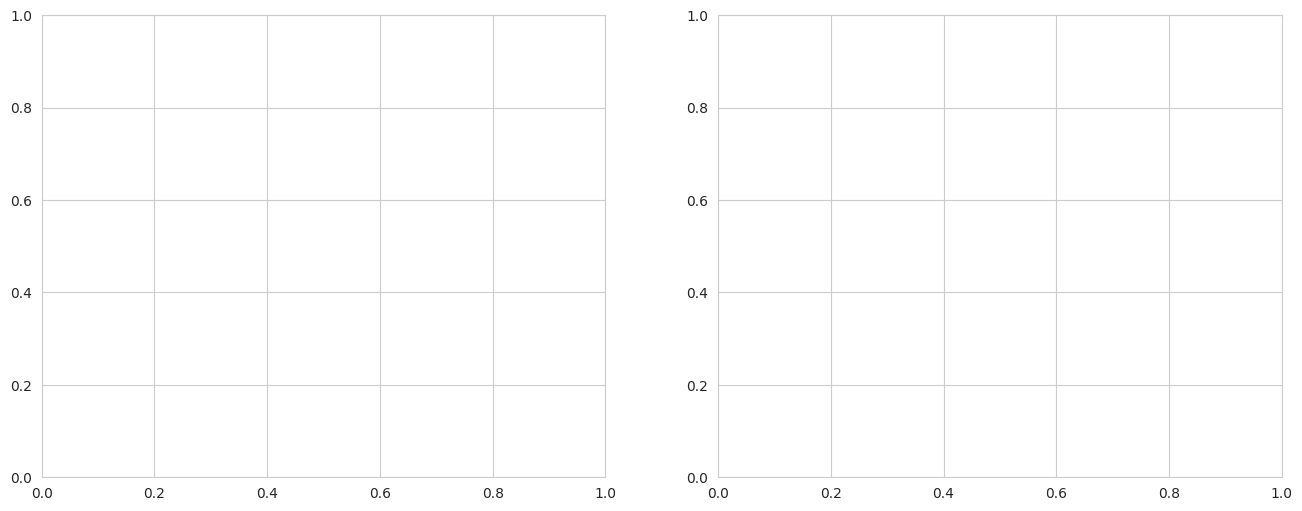

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Score Accuracy
axes[0].plot(history_df['epoch'], history_df['train_score_acc'], label='Train Score Acc', marker='o', markersize=3)
axes[0].plot(history_df['epoch'], history_df['val_score_acc'], label='Val Score Acc', marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Score Prediction Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Concede Accuracy
axes[1].plot(history_df['epoch'], history_df['train_concede_acc'], label='Train Concede Acc', marker='o', markersize=3)
axes[1].plot(history_df['epoch'], history_df['val_concede_acc'], label='Val Concede Acc', marker='s', markersize=3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Concede Prediction Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 통계
print(f"최종 Train Score Acc: {history_df['train_score_acc'].iloc[-1]:.4f}")
print(f"최종 Val Score Acc: {history_df['val_score_acc'].iloc[-1]:.4f}")
print(f"최종 Train Concede Acc: {history_df['train_concede_acc'].iloc[-1]:.4f}")
print(f"최종 Val Concede Acc: {history_df['val_concede_acc'].iloc[-1]:.4f}")

## 4. 학습 안정성 분석

In [10]:
# Loss의 변동성 계산 (이동 평균)
window = 5
history_df['train_loss_ma'] = history_df['train_loss'].rolling(window=window, min_periods=1).mean()
history_df['val_loss_ma'] = history_df['val_loss'].rolling(window=window, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history_df['epoch'], history_df['train_loss'], alpha=0.3, color='blue', label='Train Loss (Raw)')
ax.plot(history_df['epoch'], history_df['val_loss'], alpha=0.3, color='orange', label='Val Loss (Raw)')
ax.plot(history_df['epoch'], history_df['train_loss_ma'], color='blue', linewidth=2, label=f'Train Loss (MA-{window})')
ax.plot(history_df['epoch'], history_df['val_loss_ma'], color='orange', linewidth=2, label=f'Val Loss (MA-{window})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Smoothing with Moving Average')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 변동성 통계
train_loss_std = history_df['train_loss'].std()
val_loss_std = history_df['val_loss'].std()
print(f"Train Loss 표준편차: {train_loss_std:.6f}")
print(f"Val Loss 표준편차: {val_loss_std:.6f}")

NameError: name 'history_df' is not defined

## 5. Best Epoch 분석

In [11]:
best_epoch = config.get('best_epoch', history_df['val_loss'].idxmin() + 1)
best_epoch_data = history_df[history_df['epoch'] == best_epoch].iloc[0]

print(f"Best Epoch: {best_epoch}")
print(f"  - Train Loss: {best_epoch_data['train_loss']:.6f}")
print(f"  - Val Loss: {best_epoch_data['val_loss']:.6f}")
print(f"  - Train Score Acc: {best_epoch_data['train_score_acc']:.4f}")
print(f"  - Val Score Acc: {best_epoch_data['val_score_acc']:.4f}")
print(f"  - Train Concede Acc: {best_epoch_data['train_concede_acc']:.4f}")
print(f"  - Val Concede Acc: {best_epoch_data['val_concede_acc']:.4f}")

# Best epoch 이후 성능 변화
if best_epoch < len(history_df):
    epochs_after_best = len(history_df) - best_epoch
    final_val_loss = history_df['val_loss'].iloc[-1]
    best_val_loss = best_epoch_data['val_loss']
    loss_increase = final_val_loss - best_val_loss
    
    print(f"\nBest epoch 이후:")
    print(f"  - 추가 학습 에폭: {epochs_after_best}")
    print(f"  - Val Loss 증가: {loss_increase:.6f} ({loss_increase/best_val_loss*100:.2f}%)")

NameError: name 'history_df' is not defined

## 6. 다중 버전 비교 (최근 5개 버전)

In [ ]:
# 최근 5개 버전 로드
import os
models_dir = Path('../models')
versions = sorted([d for d in os.listdir(models_dir) if os.path.isdir(models_dir / d) and d != 'grid_search'], reverse=True)
comparison_versions = versions[:min(5, len(versions))]
comparison_data = []

for v in comparison_versions:
    try:
        config_path = models_dir / v / 'vaep_config.json'
        with open(config_path, 'r') as f:
            cfg = json.load(f)
        comparison_data.append({
            'version': v,
            'hidden_dims': str(cfg.get('hidden_dims', 'N/A')),
            'horizon': cfg.get('horizon', 'N/A'),
            'best_epoch': cfg.get('best_epoch', 'N/A'),
            'best_val_loss': cfg.get('best_val_loss', float('inf')),
            'input_dim': cfg.get('input_dim', 'N/A')
        })
    except:
        pass

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('best_val_loss')
    
    print("\n최근 버전 비교 (Best Val Loss 기준 정렬):")
    print(comparison_df.to_string(index=False))
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(range(len(comparison_df)), comparison_df['best_val_loss'])
    ax.set_yticks(range(len(comparison_df)))
    ax.set_yticklabels(comparison_df['version'])
    ax.set_xlabel('Best Validation Loss')
    ax.set_title('Version Comparison: Best Validation Loss')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("비교할 버전이 부족합니다.")


## 7. 하이퍼파라미터 권장사항

In [ ]:
print("=" * 60)
print("하이퍼파라미터 튜닝 권장사항")
print("=" * 60)

# Overfitting 체크
final_loss_diff = history_df['val_loss'].iloc[-1] - history_df['train_loss'].iloc[-1]
if final_loss_diff > 0.01:
    print("\n⚠️ Overfitting 감지")
    print("  권장: Dropout 증가, 정규화 추가, 또는 모델 복잡도 감소")
elif final_loss_diff < -0.005:
    print("\n⚠️ Underfitting 가능성")
    print("  권장: 모델 복잡도 증가, 학습률 조정, 또는 더 많은 에폭")
else:
    print("\n✓ 학습 안정적")

# Early stopping 체크
if 'best_epoch' in config and config['best_epoch'] < len(history_df) * 0.7:
    print("\n💡 Best epoch가 초반에 발생")
    print("  권장: Early stopping patience 조정 또는 학습률 스케줄러 사용")

# 정확도 체크
final_score_acc = history_df['val_score_acc'].iloc[-1]
final_concede_acc = history_df['val_concede_acc'].iloc[-1]
if final_score_acc < 0.95 or final_concede_acc < 0.95:
    print("\n💡 정확도 개선 여지")
    print(f"  현재 Score Acc: {final_score_acc:.4f}")
    print(f"  현재 Concede Acc: {final_concede_acc:.4f}")
    print("  권장: 피처 엔지니어링 검토 또는 모델 아키텍처 변경")

print("\n" + "=" * 60)

## 8. 학습 곡선 요약

In [ ]:
# 전체 메트릭 요약
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Train Loss
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], marker='o', markersize=2)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Val Loss
axes[0, 1].plot(history_df['epoch'], history_df['val_loss'], marker='s', markersize=2, color='orange')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Score Accuracy
axes[1, 0].plot(history_df['epoch'], history_df['train_score_acc'], label='Train', marker='o', markersize=2)
axes[1, 0].plot(history_df['epoch'], history_df['val_score_acc'], label='Val', marker='s', markersize=2)
axes[1, 0].set_title('Score Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Concede Accuracy
axes[1, 1].plot(history_df['epoch'], history_df['train_concede_acc'], label='Train', marker='o', markersize=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_concede_acc'], label='Val', marker='s', markersize=2)
axes[1, 1].set_title('Concede Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()